In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


In [ ]:
# Load the dataset
df = pd.read_csv("data/undersampled_movies_2015_2023_genres.csv")
df.head()

,title,release_year,language,genre,overview,vote_average,vote_count,popularity,cleaned_overview
0,Ava,2020,Amerikanisch,Action,black ops assassin forced fight survival job g...,5.832,2543.0,27.607,black ops assassin forced fight survival job g...
1,Infidel,2019,Amerikanisch,Action,american kidnapped attending conference cairo ...,5.500,74.0,7.443,american kidnapped attending conference cairo ...
2,Quicksand,2023,Amerikanisch,Horror,married couple brink divorce becomes trapped q...,6.589,84.0,11.736,married couple brink divorce becomes trapped q...
3,Earthquake Bird,2019,Amerikanisch,Drama,tokyo japan 1989 lucy fly foreigner work trans...,5.884,426.0,7.835,tokyo japan lucy fly foreigner work translator...
4,First Love,2022,Amerikanisch,Drama,young man difficult entry adulthood experience...,5.672,131.0,15.751,young difficult entry adulthood experience hig...


In [3]:
# Check for missing values and remove them
df_cleaned = df.dropna(subset=['cleaned_overview', 'language', 'genre'])
df_cleaned.head()

,title,release_year,language,genre,overview,vote_average,vote_count,popularity,cleaned_overview
0,Ava,2020,Amerikanisch,Action,black ops assassin forced fight survival job g...,5.832,2543.0,27.607,black ops assassin forced fight survival job g...
1,Infidel,2019,Amerikanisch,Action,american kidnapped attending conference cairo ...,5.500,74.0,7.443,american kidnapped attending conference cairo ...
2,Quicksand,2023,Amerikanisch,Horror,married couple brink divorce becomes trapped q...,6.589,84.0,11.736,married couple brink divorce becomes trapped q...
3,Earthquake Bird,2019,Amerikanisch,Drama,tokyo japan 1989 lucy fly foreigner work trans...,5.884,426.0,7.835,tokyo japan lucy fly foreigner work translator...
4,First Love,2022,Amerikanisch,Drama,young man difficult entry adulthood experience...,5.672,131.0,15.751,young difficult entry adulthood experience hig...


In [4]:
# Combine the 'cleaned_overview' and 'genre' columns 
df_cleaned.loc[:, 'combined_text'] = df_cleaned['cleaned_overview'] + ' ' + df_cleaned['genre']

In [5]:
# Define features (X) and target (y)
X = df_cleaned['combined_text']
y = df_cleaned['language']

In [6]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Extraction Using TF-IDF

In [7]:
# Handle missing values by replacing NaN with an empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')


In [8]:
# Use TF-IDF Vectorizer to extract features
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=30000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [9]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the 'language' column
y_encoded = label_encoder.fit_transform(df['language'])

# Print the mapping of languages to numerical labels
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'Amerikanisch': np.int64(0), 'Deutsch': np.int64(1), 'Französisch': np.int64(2), 'Indisch': np.int64(3), 'Italienisch': np.int64(4), 'Spanisch': np.int64(5)}


## Implementing KNN Classifier

In [10]:
# Initialize the KNN classifier with default parameters
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine', weights='distance')

# Train the KNN model
knn.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = knn.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Initial Test Accuracy: {accuracy:.3f}')
print(classification_report(y_test, y_pred))


Initial Test Accuracy: 0.497
              precision    recall  f1-score   support

Amerikanisch       0.46      0.47      0.46       313
     Deutsch       0.55      0.48      0.51       307
 Französisch       0.46      0.43      0.44       293
     Indisch       0.64      0.65      0.64       320
 Italienisch       0.46      0.51      0.48       282
    Spanisch       0.42      0.44      0.43       309

    accuracy                           0.50      1824
   macro avg       0.50      0.50      0.50      1824
weighted avg       0.50      0.50      0.50      1824



## Hyperparameter Tuning with Grid Search

In [11]:
# Define the parameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],  # we tried with different neighbor counts
    'weights': ['uniform', 'distance'],  # Uniform or distance-weighted
    'metric': ['cosine']  # We stick with cosine similarity
}

In [12]:
# Use GridSearchCV to find the best hyperparameters
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_knn.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/codespace/.local/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['cosine'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [13]:
# Output the best parameters and the best score
print(f'Best parameters: {grid_search_knn.best_params_}')
print(f'Best cross-validation accuracy: {grid_search_knn.best_score_:.3f}')

Best parameters: {'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}
Best cross-validation accuracy: 0.526


## Evaluating the Model

In [14]:
# Make predictions on the test set with the best model
best_knn = grid_search_knn.best_estimator_
y_pred_best = best_knn.predict(X_test_tfidf)

In [15]:
# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Test Accuracy after tuning: {accuracy_best:.3f}')
print(classification_report(y_test, y_pred_best))

Test Accuracy after tuning: 0.539
              precision    recall  f1-score   support

Amerikanisch       0.49      0.53      0.51       313
     Deutsch       0.62      0.51      0.56       307
 Französisch       0.51      0.48      0.50       293
     Indisch       0.69      0.66      0.68       320
 Italienisch       0.51      0.55      0.53       282
    Spanisch       0.44      0.50      0.47       309

    accuracy                           0.54      1824
   macro avg       0.54      0.54      0.54      1824
weighted avg       0.55      0.54      0.54      1824



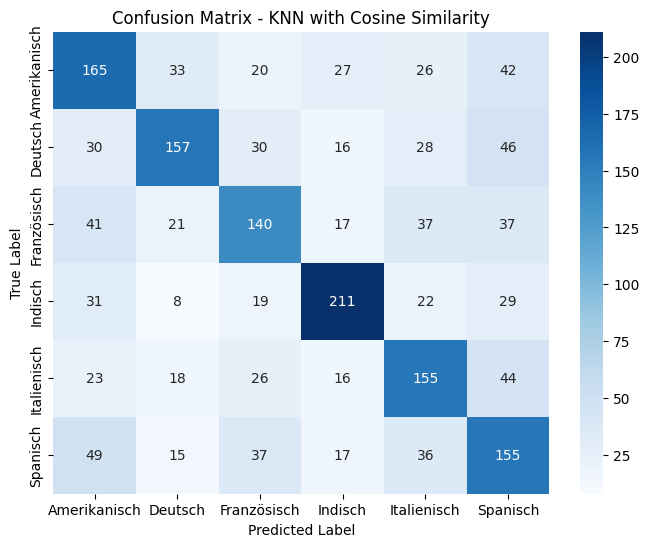

In [16]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN with Cosine Similarity')
plt.show()
